In [ ]:
import math, os, sys, torch, pyro, pyro.optim, pyro.infer
import numpy as np
from torch.autograd import Variable, grad, Function
from torch.autograd.function import once_differentiable
from pyro.distributions import Distribution
from matplotlib import pyplot
%matplotlib inline
torch.set_default_tensor_type('torch.DoubleTensor')
from torch.optim import Adam

In [422]:
class BivariateNormal(Distribution):
    reparameterized = True
    
    def __init__(self, loc, scale_triu, batch_size=None):
        self.loc = loc
        self.scale_triu = scale_triu
        self.batch_size = 1 if batch_size is None else batch_size

    def batch_shape(self, x=None):
        loc = self.loc.expand(self.batch_size, *self.loc.size()).squeeze(0)
        if x is not None:
            if x.size()[-1] != loc.size()[-1]:
                raise ValueError("The event size for the data and distribution parameters must match.\n"
                                 "Expected x.size()[-1] == self.loc.size()[0], but got {} vs {}".format(
                                     x.size(-1), loc.size(-1)))
            try:
                loc = loc.expand_as(x)
            except RuntimeError as e:
                raise ValueError("Parameter `loc` with shape {} is not broadcastable to "
                                 "the data shape {}. \nError: {}".format(loc.size(), x.size(), str(e)))

        return loc.size()[:-1]

    def event_shape(self):
        return self.loc.size()[-1:]

    def sample(self):
        return self.loc + torch.mv(self.scale_triu.t(), Variable(torch.randn(self.loc.size())), )

    def batch_log_pdf(self, x):
        delta = x - self.loc
        z0 = delta[..., 0] / self.scale_triu[..., 0, 0]
        z1 = (delta[..., 1] - self.scale_triu[..., 0, 1] * z0) / self.scale_triu[..., 1, 1]
        z = torch.stack([z0, z1], dim=-1)
        mahalanobis_squared = (z ** 2).sum(-1)
        normalization_constant = self.scale_triu.diag().log().sum(-1) + np.log(2 * np.pi)
        return -(normalization_constant + 0.5 * mahalanobis_squared).unsqueeze(-1)

    def entropy(self):
        return self.scale_triu.diag().log().sum() + (1 + math.log(2 * math.pi))
    
def _BVN_backward_reptrick(white, scale_triu, grad_output):   
    grad = (grad_output.unsqueeze(-1) * white.unsqueeze(-2)).squeeze(0)  
    return grad_output, torch.triu(grad.t())
        
def _BVN_backward_symm(white, scale_triu, grad_output):
    grad = (grad_output.unsqueeze(-1) * white.unsqueeze(-2)).squeeze(0)
    x = torch.trtrs(white.t(), scale_triu, transpose=False)[0].t()
    y = torch.mm(scale_triu, grad_output.t()).t()
    grad += (x.unsqueeze(-1) * y.unsqueeze(-2)).squeeze(0)
    grad *= 0.5
    return grad_output, torch.triu(grad.t())

def _BVN_backward_sliding(white, scale_triu, grad_output):
    grad = (2-t) * (grad_output.unsqueeze(-1) * white.unsqueeze(-2)).squeeze(0)
    x = torch.trtrs(white.t(), scale_triu, transpose=False)[0].t()
    y = torch.mm(scale_triu, grad_output.t()).t()
    grad += t * (x.unsqueeze(-1) * y.unsqueeze(-2)).squeeze(0)
    grad *= 0.5
    return grad_output, torch.triu(grad.t())
    
class _RepTrickSample(Function):
    @staticmethod
    def forward(ctx, loc, scale_triu):
        ctx.save_for_backward(scale_triu)
        ctx.white = loc.new(loc.size()).normal_()    
        return loc + torch.mm(ctx.white, scale_triu)
 
    @staticmethod
    def backward(ctx, grad_output):
        scale_triu, = ctx.saved_variables
        return _BVN_backward_reptrick(Variable(ctx.white), scale_triu, grad_output)    

class _SymmetricSample(Function):
    @staticmethod
    def forward(ctx, loc, scale_triu):
        ctx.save_for_backward(scale_triu)
        ctx.white = loc.new(loc.size()).normal_()
        return loc + torch.mm(ctx.white, scale_triu)
 
    @staticmethod
    @once_differentiable    
    def backward(ctx, grad_output):
        scale_triu, = ctx.saved_tensors
        return _BVN_backward_symm(ctx.white, scale_triu, grad_output)    

class _CanonicalSample(Function):
    @staticmethod
    def forward(ctx, loc, scale_triu):
        ctx.save_for_backward(scale_triu)
        ctx.white = loc.new(loc.size()).normal_()
        ctx.z = torch.mm(ctx.white, scale_triu)
        return loc + ctx.z
 
    @staticmethod
    @once_differentiable    
    def backward(ctx, grad_output):
        scale_triu, = ctx.saved_tensors
        return _BVN_backward_canonical(ctx.white, scale_triu, grad_output, ctx.z)       
    

class BivariateNormalRepTrick(BivariateNormal):
    def sample(self):
        loc = self.loc.expand(self.batch_size, *self.loc.size())
        return _RepTrickSample.apply(loc, self.scale_triu)

class BivariateNormalSymmetric(BivariateNormal):
    def sample(self):
        loc = self.loc.expand(self.batch_size, *self.loc.size())
        return _SymmetricSample.apply(loc, self.scale_triu)
    
class BivariateNormalCanonical(BivariateNormal):
    def sample(self):
        loc = self.loc.expand(self.batch_size, *self.loc.size())
        return _CanonicalSample.apply(loc, self.scale_triu)   
    
def _BVN_backward_canonical(white, scale_triu, grad_output, z):
    # white        [1,2]
    # grad_output  [1,2]
    # z            [1,2]
    g = grad_output
    epsilon = white
    epsilon_b = white.unsqueeze(-1).squeeze(0)
    g_a = g.unsqueeze(-2).squeeze(0)
    diff_R_ba = 0.5 * epsilon_b * g_a
    
    z_a = z.unsqueeze(-2).squeeze(0)
    R_invT_g_b = torch.trtrs(g.squeeze(0), scale_triu, transpose=True)[0]
    diff_R_ba += 0.5 * R_invT_g_b * z_a
    
    Sigma = torch.mm(scale_triu.t(), scale_triu) 
    Sigma_inv = torch.inverse(Sigma)    
    V, D, _ = torch.svd(Sigma_inv)
    D_outer = D.unsqueeze(-1) + D.unsqueeze(0)
    
    R_inv = torch.eye(2).type_as(g)
    R_inv = torch.trtrs(R_inv, scale_triu, transpose=False)[0]    
    R_inv_ib = R_inv.t().unsqueeze(1).unsqueeze(-1)    
    xi = 0.5 * R_inv_ib * Sigma_inv.unsqueeze(1)
    
    delta_ai = torch.eye(2).type_as(g).unsqueeze(2)
    Sigma_inv_R_inv_jb = torch.mm(Sigma_inv, R_inv).t().unsqueeze(1).unsqueeze(1)    
    xi -= 0.5 * delta_ai * Sigma_inv_R_inv_jb
    
    Xi = xi + torch.transpose(xi.clone(), 2, 3)
    Xi_tilde = torch.matmul(V.t(), torch.matmul(Xi, V))
    S_tilde = Xi_tilde / D_outer
    S = torch.matmul(V, torch.matmul(S_tilde, V.t()))
    
    S_z = torch.matmul(S, z.t())
    S_z_g = torch.matmul(g, S_z).squeeze(-1).squeeze(-1)    
    diff_R_ba += S_z_g    

    return grad_output, torch.triu(diff_R_ba)

In [423]:
mu = Variable(torch.zeros(2))
off_diag = Variable(1.3*torch.ones(2,2), requires_grad=True)
R = Variable(torch.diag(torch.ones(2))) + torch.triu(off_diag,1)
dist = BivariateNormalCanonical(mu, R)
dist.sample().sum().backward()

In [6]:
def do_test(symm=True, n_steps=35000, n_trials=100):
    mses = []
    for _ in range(n_trials):
        mu = Variable(torch.zeros(2))
        off_diag = Variable(-6.0*torch.ones(2,2), requires_grad=True)
        opt = Adam([off_diag], lr = 0.01, betas=(0.96, 0.999))

        for _ in range(n_steps):
            R = Variable(torch.diag(torch.ones(2))) + torch.triu(off_diag,1)
            dist = BivariateNormalSymmetric(mu, R) if symm else BivariateNormalRepTrick(mu, R)
            z = dist.sample()
            loss = -torch.cos(z.sum())
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        mse = (off_diag.data.numpy()[0,1] + 1.0) ** 2
        mses.append(mse)
        
    return np.array(mses)

symm_results = do_test(symm=True)
rt_results = do_test(symm=False)
print("symm: ", np.mean(symm_results), np.min(symm_results), np.max(symm_results))
print("rt:   ", np.mean(rt_results), np.min(rt_results), np.max(rt_results))

    

KeyboardInterrupt: 

In [ ]:
rt_results

In [496]:
def analytic_grad(theta=1.0, omega1=1.0, omega2=1.0):
    fact_1 = -omega2*(omega1+omega2*theta)
    fact_2 = np.exp(-0.5*omega2**2)
    fact_3 = np.exp(-0.5*(omega1+omega2*theta)**2)
    return fact_1*fact_2*fact_3
    

def compute_var(symm=True, n_samples=100000, theta=1.0, omega1=1.0, omega2=1.0):
    grads = []
    omega = Variable(torch.Tensor([omega1, omega2]))
    mu = Variable(torch.zeros(2))
    off_diag = Variable(theta*torch.ones(2,2), requires_grad=True)

    for _ in range(n_samples):
        R = Variable(torch.diag(torch.ones(2))) + torch.triu(off_diag,1)
        dist = BivariateNormalCanonical(mu, R) if symm else BivariateNormalRepTrick(mu, R)
        #dist = BivariateNormalSliding(mu, R, t=t)
        z = dist.sample()
        obj = torch.cos((omega*z).sum())
        obj.backward()
        grads.append(off_diag.grad.clone().data.numpy()[0,1])
        off_diag.grad.data.zero_()
        
    analytic = analytic_grad(theta=theta, omega1=omega1, omega2=omega2)
    variance = np.mean(np.power(np.array(grads) - analytic, 2.0))
    return variance

thetas = (np.arange(51) - 25)/4.0
symm_vars = []
rt_vars = []
for theta in thetas:
    symm_vars.append(compute_var(symm=True, theta=theta))
    rt_vars.append(compute_var(symm=False, theta=theta))

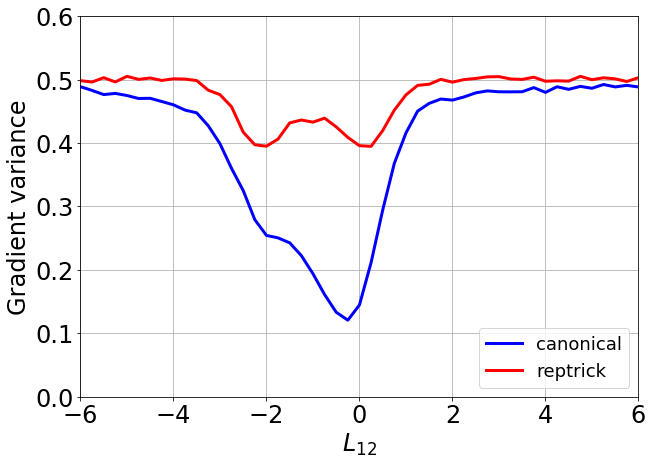

In [501]:
fig = pyplot.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.plot(thetas, symm_vars, color='blue', label='canonical', lw=3)
ax.plot(thetas, rt_vars, color='red', label='reptrick', lw=3)
ax.grid()
ax.set_ylim(0, 0.6)
ax.set_xlim(-6,6)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)
ax.set_xlabel('$L_{12}$', fontsize=24)
ax.set_ylabel('Gradient variance', fontsize=24)
ax.legend(loc='lower right',fontsize=18)
pyplot.savefig('mvn_variance.pdf')
pyplot.show()

In [424]:
def compute_mean(symm=True, n_samples=10000, theta=1.0, omega1=1.0, omega2=1.0):
    grads = []
    omega = Variable(torch.Tensor([omega1, omega2]))
    mu = Variable(torch.zeros(2))
    off_diag = Variable(theta*torch.ones(2,2), requires_grad=True)

    for _ in range(n_samples):
        R = Variable(torch.diag(torch.ones(2))) + torch.triu(off_diag,1)
        dist = BivariateNormalCanonical(mu, R) if symm else BivariateNormalRepTrick(mu, R)
        z = dist.sample()
        obj = torch.cos((omega*z).sum())
        obj.backward()
        grads.append(off_diag.grad.clone().data.numpy()[0,1])
        off_diag.grad.data.zero_()
        
    analytic = analytic_grad(theta=theta, omega1=omega1, omega2=omega2)
    stochastic = np.mean(grads)
    return stochastic, analytic

thetas = (np.arange(31) - 15)/6.0
symm_means = []
rt_means = []
analytic_means = []
for theta in thetas:
    symm, analytic = compute_mean(symm=True, theta=theta, omega1=0.6, omega2=1.9)
    rt, _ = compute_mean(symm=False, theta=theta, omega1=0.6, omega2=1.9)
    symm_means.append(symm)
    rt_means.append(rt)
    analytic_means.append(analytic)

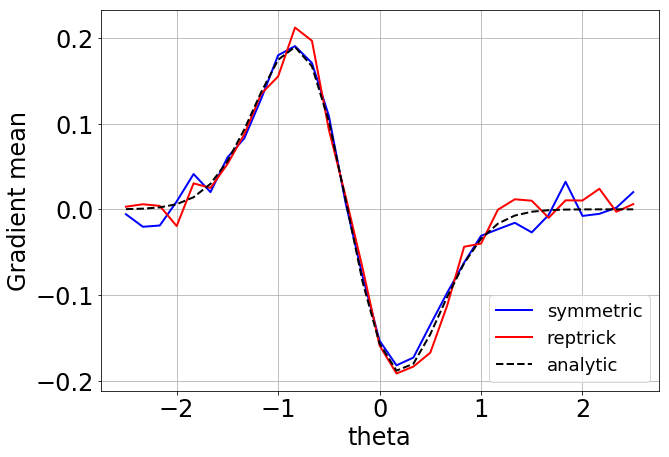

In [425]:
fig = pyplot.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.plot(thetas, symm_means, color='blue', label='symmetric', lw=2)
ax.plot(thetas, rt_means, color='red', label='reptrick', lw=2)
ax.plot(thetas, analytic_means, color='black', label='analytic', lw=2, ls='--')
ax.grid()
#ax.set_ylim(0, 1)
#ax.set_xlim(-3,1)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.tick_params(axis='both', which='minor', labelsize=24)
ax.set_xlabel('theta', fontsize=24)
ax.set_ylabel('Gradient mean', fontsize=24)
ax.legend(loc='lower right',fontsize=18)
#pyplot.savefig('mvn_variance.pdf')
pyplot.show()

In [492]:
CanonicalBeta_bias =  [2.0955032606490009e-06, -1.095710942644601e-06, -3.7560131423411067e-06, -1.9640211184886007e-06, -1.9258349603644724e-06, -6.6252221198048744e-07, 1.4200268465269783e-06, 2.4761035969098674e-06, -1.0138546183704415e-06, -9.2437488080632235e-07, 4.428725915717191e-07, 7.9736689040377229e-07, 1.7488345320781917e-06, -6.8098311650777177e-07, 7.0502409921214225e-07, 7.3137288711389026e-07, 5.2347200633895679e-07, 5.2803159331094029e-07, 4.2253786227541964e-07, -1.7203225224915464e-07, -1.4304748198470875e-07, -1.1494020105837157e-07, -2.8460057671653161e-08]
CanonicalBeta_variance =  [0.0067374292, 0.0031479544, 0.0017219057, 0.0010323456, 0.00065850822, 0.00043928751, 0.000303799, 0.00021619847, 0.00015775053, 0.00011769828, 8.9568966e-05, 6.9376758e-05, 5.4625529e-05, 4.362268e-05, 1.7130898e-05, 4.8909706e-06, 2.0910293e-06, 1.0690438e-06, 6.0427271e-07, 3.6594517e-07, 2.3293138e-07, 1.5443395e-07, 1.0586199e-07]
RejectionBeta_bias =  [-1.0225647191636211e-06, 6.5894321849446769e-05, -3.8551989965376551e-06, 7.830465568098733e-06, 6.3611702708088209e-07, 3.1812788841012463e-06, -2.7739682964683654e-05, 5.0346795400222407e-06, -1.0053562998770752e-06, -1.1041564839497919e-05, -2.5140765828324252e-06, -4.1188521503476849e-06, -7.534821722332552e-06, -4.1110441588165791e-06, -5.1632394434399879e-06, -3.8358330188004164e-06, -2.475386683922884e-06, -2.205632993829143e-06, -1.9883652450994869e-06, -1.4747197034925552e-06, -8.9624006228974863e-07, -5.708662570783334e-07, -5.6878722201614274e-07]
RejectionBeta_variance =  [0.01016889, 0.0046293326, 0.0024806864, 0.0014639213, 0.00092251867, 0.000611266, 0.00042030661, 0.00029825902, 0.00021699758, 0.00016175723, 0.0001232871, 9.5344774e-05, 7.5077631e-05, 5.9851911e-05, 2.3396928e-05, 6.4394362e-06, 2.6270177e-06, 1.2990674e-06, 7.1736997e-07, 4.2544733e-07, 2.6656087e-07, 1.7471592e-07, 1.189046e-07]
RejectionBeta_bias =  [-1.0225647191636211e-06, 6.8857235218100499e-06, 1.1270410937792331e-05, -6.0257516970303564e-06, -1.5966706378988142e-06, 2.8964687992516502e-06, -6.5694402751337311e-06, 1.3834293862422572e-06, 1.0889553397894821e-06, -2.4240370565808966e-06, -3.0593659502697879e-06, -4.6999974369077435e-06, -3.9722800437846928e-06, -5.715014462948087e-06, -3.336100967366246e-06, -4.5014958290068297e-06, -2.7686950872658463e-06, -2.3197782168804526e-06, -1.795232226188602e-06, -1.36392142094377e-06, -1.1155374247812371e-06, -8.5481777892945578e-07, -6.9969625141053093e-07]
RejectionBeta_variance =  [0.01016889, 0.0046313163, 0.002481204, 0.0014630131, 0.00092221791, 0.00061098643, 0.00042014208, 0.00029810792, 0.00021709508, 0.00016184192, 0.00012314813, 9.5352843e-05, 7.5079784e-05, 5.9963862e-05, 2.342124e-05, 6.4358323e-06, 2.6288253e-06, 1.3000537e-06, 7.1648714e-07, 4.2535206e-07, 2.6689597e-07, 1.7502568e-07, 1.1906714e-07]

CanonicalBeta_bias =  [-1.1373353662633146e-05, 6.5118324326984837e-06, -2.1112043433127101e-06, -1.8229606730309037e-06, -1.4643988216432895e-06, -3.4273380840499358e-06, -4.0177835261556716e-07, 5.0898879306294188e-07, -3.5183570996857265e-06, 1.4197582187347458e-06, -3.1063139971920786e-07, 1.5195406082080253e-06, 1.3958370828515143e-06, -1.0725897072183521e-06, 5.5030668131262307e-07, 7.2917991348897542e-07, 7.4330487931084919e-07, 7.0957619452971523e-07, 1.9913467690224748e-07, -2.0735593507237303e-07, -1.5363072613241925e-07, -2.3236833618520072e-07, -3.8476868519099482e-08]
CanonicalBeta_variance =  [0.0067377379, 0.0031476538, 0.0017217852, 0.001032077, 0.00065800396, 0.00043916609, 0.00030379571, 0.00021624118, 0.00015774893, 0.00011771594, 8.9523281e-05, 6.943295e-05, 5.4615528e-05, 4.3594406e-05, 1.7137227e-05, 4.891469e-06, 2.0908806e-06, 1.0685405e-06, 6.0468921e-07, 3.6604715e-07, 2.3297628e-07, 1.545354e-07, 1.059413e-07]
RejectionBeta_bias =  [2.0558787037885939e-05, 1.7088304119061704e-05, -6.2701533571121393e-06, -5.3283162351143266e-06, -1.0751292685183848e-06, -1.2095536255696259e-06, -1.4851145992811344e-06, -5.522190716528369e-06, -5.7063074034637791e-06, -2.247999627680297e-06, -3.7135531201271109e-06, -1.3957551640464416e-06, -2.826069336991921e-06, -2.7828792143913541e-06, -4.4900372859537581e-06, -3.5114082551246374e-06, -2.3458942834759774e-06, -2.2799117899208187e-06, -2.0001806726691595e-06, -1.3707044324295925e-06, -1.0188503163283395e-06, -9.2396957148829714e-07, -5.9692244061548827e-07]
RejectionBeta_variance =  [0.010172777, 0.0046308748, 0.0024803679, 0.001463688, 0.00092329102, 0.00061138533, 0.000420183, 0.00029802657, 0.00021724109, 0.000161769, 0.00012301006, 9.5359246e-05, 7.5126271e-05, 5.9930037e-05, 2.34204e-05, 6.4311484e-06, 2.6292757e-06, 1.2992375e-06, 7.168519e-07, 4.2538596e-07, 2.6683614e-07, 1.7514409e-07, 1.1892602e-07]

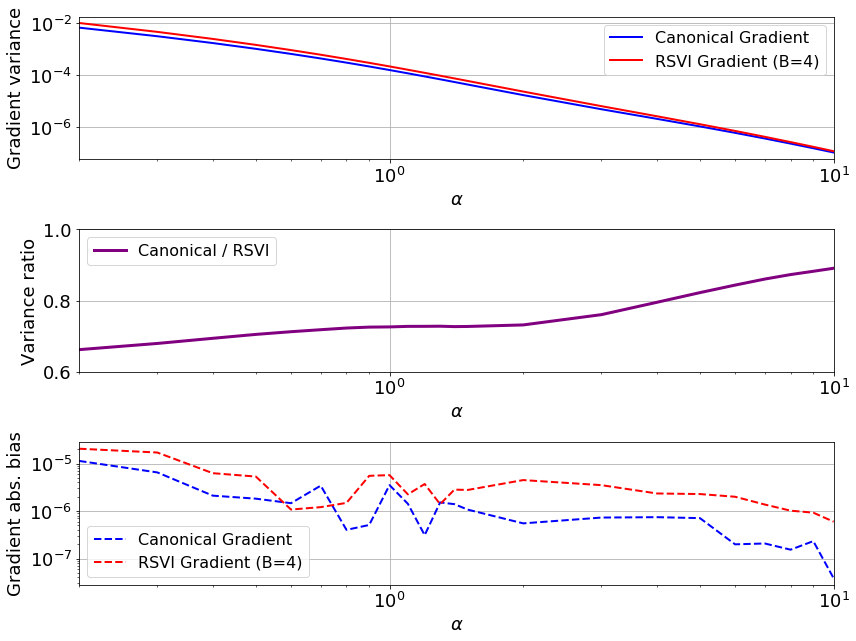

In [493]:
alphas = list((2+np.arange(14))/10.0)
alphas += list(2+np.arange(9))

f, (ax1, ax3, ax2) = pyplot.subplots(3, 1, figsize=(12,9))

CanonicalBeta_bias = np.abs(np.array(CanonicalBeta_bias))
CanonicalBeta_var = np.array(CanonicalBeta_variance)
RejectionBeta_bias = np.abs(np.array(RejectionBeta_bias))
RejectionBeta_var = np.array(RejectionBeta_variance)

ax2.loglog(alphas, CanonicalBeta_bias, color='blue', label='Canonical Gradient', lw=2, ls='--')
ax1.loglog(alphas, CanonicalBeta_var, color='blue', label='Canonical Gradient', lw=2)
ax2.loglog(alphas, RejectionBeta_bias, color='red', label='RSVI Gradient (B=4)', lw=2, ls='--')
ax1.loglog(alphas, RejectionBeta_var, color='red', label='RSVI Gradient (B=4)', lw=2)
ax3.semilogx(alphas, CanonicalBeta_var/RejectionBeta_var, color='purple', label='Canonical / RSVI', lw=3)

ax1.grid()
ax2.grid()
ax3.grid()
ax3.set_ylim(0.6, 1.0)
ax1.set_xlim(0.2,10.0)
ax2.set_xlim(0.2,10.0)
ax3.set_xlim(0.2,10.0)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax1.tick_params(axis='both', which='minor', labelsize=18)
ax1.set_xlabel('$\\alpha$', fontsize=18)
ax1.set_ylabel('Gradient variance', fontsize=18)
ax1.legend(loc='upper right',fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='minor', labelsize=18)
ax2.set_xlabel('$\\alpha$', fontsize=18)
ax2.set_ylabel('Gradient abs. bias', fontsize=18)
ax2.legend(loc='lower left',fontsize=16)
ax3.tick_params(axis='both', which='major', labelsize=18)
ax3.tick_params(axis='both', which='minor', labelsize=18)
ax3.set_xlabel('$\\alpha$', fontsize=18)
ax3.set_ylabel('Variance ratio', fontsize=18)
ax3.legend(loc='upper left',fontsize=16)
pyplot.savefig('beta_moments.pdf')
pyplot.tight_layout()
pyplot.show()